# Support Agent Eval

Datasets:
- https://www.kaggle.com/datasets/tobiasbueck/email-ticket-text-german-classification

## Setup

In [1]:
# %%bash
# pip install dtale ydata-profiling jupyter-summarytools

In [2]:
%matplotlib inline

In [3]:
import os
import json
import random
import logging
import importlib
import pandas as pd
from tqdm import tqdm
from pprint import pprint
from openai import OpenAI

import dtale
from summarytools import dfSummary
from ydata_profiling import ProfileReport

In [4]:
import calc_scores
importlib.reload(calc_scores) # reload local import in case of changes
from calc_scores import calculate_scores, plot_confusion_matrix

In [5]:
logging.getLogger().setLevel(logging.WARNING)

random.seed(42)

In [6]:
client = OpenAI(base_url="http://localhost:1234/v1", api_key="lm-studio")

In [7]:
# Directory containing the CSV files
csv_dir = './data/raw'

# Iterate over all files in the directory
for filename in os.listdir(csv_dir):
    if filename.endswith('.csv'):
        file_path = os.path.join(csv_dir, filename)
        df = pd.read_csv(file_path)
        print(f'File: {filename}')
        print(f'Number of columns: {df.shape[1]}')
        print(f'Number of rows: {df.shape[0]}')
        print('---')

File: ticket_helpdesk_labeled_multi_languages_english_spain_french_german.csv
Number of columns: 8
Number of rows: 200
---


In [8]:
ticket_helpdesk_path = os.path.join(
    csv_dir, "ticket_helpdesk_labeled_multi_languages_english_spain_french_german.csv"
)
ticket_helpdesk = pd.read_csv(ticket_helpdesk_path)
ticket_helpdesk.head(3)

,queue,priority,software_used,hardware_used,accounting_category,language,subject,text
0,Hardware,2,NaN,Wireless Mouse,NaN,en,Wireless Mouse suddenly stops working,"Dear Support Team, I've been using the Wireles..."
1,Hardware,2,NaN,IP PBX,NaN,fr,Problème de connexions IP PBX,"Bonjour, nous rencontrons un problème avec not..."
2,Hardware,2,NaN,SFX-Netzteil,NaN,de,Problem mit meinem SFX-Netzteil,"Sehr geehrte Damen und Herren, mein SFX-Netzte..."


In [9]:
ticket_helpdesk.rename(columns={'queue': 'department'}, inplace=True)
ticket_helpdesk.head()

,department,priority,software_used,hardware_used,accounting_category,language,subject,text
0,Hardware,2,NaN,Wireless Mouse,NaN,en,Wireless Mouse suddenly stops working,"Dear Support Team, I've been using the Wireles..."
1,Hardware,2,NaN,IP PBX,NaN,fr,Problème de connexions IP PBX,"Bonjour, nous rencontrons un problème avec not..."
2,Hardware,2,NaN,SFX-Netzteil,NaN,de,Problem mit meinem SFX-Netzteil,"Sehr geehrte Damen und Herren, mein SFX-Netzte..."
3,Accounting,2,NaN,NaN,Customer Inquiries::Technical Support,en,Invoice Adjustment Request,"Dear Customer Support,\nI recently received my..."
4,Software,2,Arbitrum,NaN,NaN,en,Issue with Arbitrum: UI not loading,"Hello Support Team,\nI've been experiencing an..."


## EDA

In [10]:
d = dtale.show(ticket_helpdesk, notebook=False, browser=True)
d._main_url

'http://Saschas-MacBook-Pro.fritz.box:40000/dtale/main/1'

In [ ]:
profile = ProfileReport(ticket_helpdesk, title="Profiling Report")
profile.to_file("ticket_helpdesk_profiling_report.html")
# profile.to_notebook_iframe()

In [12]:
dfSummary(ticket_helpdesk)

2024-12-19 10:07:16,986 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-12-19 10:07:16,986 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,department[object],1. Software2. Hardware3. Accounting,83 (41.5%)66 (33.0%)51 (25.5%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABlUlEQVR4nO3bQWrCUBRG4ZsSpJ0kBMHFuIgutovIbkR8gypO0oE7KHjuy3vnW8EVDkqC/7BtW0iEj+wD1I8hIr4i4pB9SKLntm337CN6MB6Px+9pmpbsQ7KUUq7DMPwY3PuN0zQt5/P5Ps/zI/sY2u12+1zXdblcLoeIMLY3GyMi5nl+nE6n3+xjknxlH9ALHxCEMTZhjE0YYxPG2IQxNmGMTRhjE8bYhDE2YYxNGGMTxtiEMTZhxojX/7qyD8nQ6+fOMpZSruu6LtHp/7pKKdeIeGbf0QM3CG4QMINTPlFa+2bzW6piTa2rXErVrZl1lUup+rW2ruryiXovfKkrjLEJY2zCGJswxiaMsQljbMIYmzDGJoyxCWNswhibMMYmjLEJ08y6qoXP0Lqm1lUupermBkEY11XC+IAgzB5+Rv1pbET1Uz7nee2oesrnPK8te5jy7f6VjF58QBDG2IQxNmGMTRhjE8bYhDE2YYxNGGMTxtiEMTZhjE0YYxPG2ISpespX6136n+qnfM7z2uEGQRinfML8AUq8o0qVu8MrAAAAAElFTkSuQmCC"">",0(0.0%)
2,priority[int64],1. 32. 23. 1,84 (42.0%)71 (35.5%)45 (22.5%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABlUlEQVR4nO3bQWrCUBRG4ZsSpE4SRHAxLqKL7SKyGxHfoIqTdOCgK/Dc15vzreAKByXBf1jXNSTCR/YB2o4hIvYRscs+JNlzXdd79hHVjcfj8WuapkP2IZlaa9dhGL4N7r3GaZoO5/P5Ps/zI/uYDLfb7XNZlsPlctlFhLG90RgRMc/z43Q6/WQfk2iffcAW+IAgjLEJY2zCGJswxiaMsQljbMIYmzDGJoyxCWNswhibMMYmjLEJM0a8/tOVfUiWLX922thauy7LcogN/6ertXaNiGf2HdW5QXhxgwAYnPKJUv2bzW+sjpReV7ma6kvZdZWrqf5UX1dt9gm7R77UFcbYhDE2YYxNGGMTxtiEMTZhjE0YYxPG2IQxNmGMTRhjE8bYhCm7rqr4mf670usqV1N9cYMgjOsqYXxAEKa3n1F/9grrasrn9K62bqZ8Tu/q623KV+71i/74gCCMsQljbMIYmzDGJoyxCWNswhibMMYmjLEJY2zCGJswxiaMsQnTzZSvhxv0Xl1N+Zze1eYGQRinfML8Akq8o0pbUPLaAAAAAElFTkSuQmCC"">",0(0.0%)
3,software_used[object],1. nan2. Sales Forecasting3. Grafana4. P2P Lending5. Financial Analysis6. SAP Business Suite7. Angel Investing8. Oracle VM VirtualBox9. Mobile Security10. Squarespace11. other,117 (58.5%)3 (1.5%)1 (0.5%)1 (0.5%)1 (0.5%)1 (0.5%)1 (0.5%)1 (0.5%)1 (0.5%)1 (0.5%)72 (36.0%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAAEDklEQVR4nO3cwW0bVwBF0U+CUKzNEAQBlaECWISKTREsQH0IBGdhKtooC8tBCgjvKOQ5FXwb16PR4D+vPj8/BxTWSx+A+yE2MmIjIzYyYiMjNjJiIyM2MmIjsxpjPI4xHpY+yJ34+Pz8vCx9iKVs9vv9yzRNu6UPcg/meT6tVqs/7zW4zTRNu8PhcNlut+9LH+aWnc/nH8fjcff29vYwxrjP2MYYY7vdvj89Pf1c+jB34HHpAyzJLwhkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZmM8avu1ZLH+TW+TseYzPP8+l4PO7Gnd+1KszzfBpjfCx9jqXYILTueoOw8l9mUfn3k+2u/9Vxff+sq+59+cP1radp2j0/P4+vOZ93N65mPcYYj4+Pfy19EG6fj7pkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxk1mOMcblc/lj6INy+9TzPp9fX17sfY3B9roWTMXgh8/vJNjzVuLbNfr9/GWMMYxeubT1N087YhYLvbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZDZfQ5cxjF24MtfCyRi8kPHORsaPUTLWVWSsq8h4ZyMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiI2NdRca1cDLWVWQ82cgYvJAxeCHj0wcZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmDFzKuhZMxeCHjyUbG4IWMwQsZnz7IiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYx1FRkbBDLWVWQ82chYV5GxriLj0wcZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmDFzKuhZMxeCHjyUbG4IWMwQsZnz7IiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MgYvJBxLZyMwQsZ72xk/BglY11FxrqKjHc2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkXAsnY11FxpONjMELGYMXMj59kBEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXgh41o4GYMXMr+fbLd8JfzDU/t72Oz3+5evDcJNmuf5ZMzzPWymadodDofLdrt9X/ow/7Xz+fzjeDzu3t7eHsYYYlvYZowxttvt+9PT08+lD3Mlj0sfgF98ZyMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiOzGePXVZylD3INt/rn+r/azPN8Oh6Pu3GjV3G+Bj3GPN+Aa+FkDF7I+AWBjNjIiI2M2MiIjYzYyIiNjNjIiI3M31hLQMhMfJg4AAAAAElFTkSuQmCC"">",117(58.5%)
4,hardware_used[object],1. nan2. IP PBX3. Ringlicht4. NAS-Gehäuse5. Wireless Mouse6. Accelerometer7. Das Keyboard 4 Professional8. Smart-Gartenbeleuchtung9. Externe Festplatte10. Smart Home Hub11. other,134 (67.0%)2 (1.0%)2 (1.0%)2 (1.0%)1 (0.5%)1 (0.5%)1 (0.5%)1 (0.5%)1 (0.5%)1 (0.5%)54 

## Data Preprocessing & Cleaning

In [13]:
# Drop columns with missing values
ticket_helpdesk = ticket_helpdesk.drop(columns=['software_used', 'hardware_used', 'accounting_category'])

In [14]:
# Keep only de and en languages
ticket_helpdesk = ticket_helpdesk[ticket_helpdesk['language'].isin(['de', 'en'])]

In [15]:
dfSummary(ticket_helpdesk[["language", "department", "priority"]])

2024-12-19 10:07:17,420 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-12-19 10:07:17,421 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,language[object],1. en2. de,78 (62.4%)47 (37.6%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABN0lEQVR4nO3bQWrDMBCF4VExodlIGIMP40P0sD2EbmOMtWhCNuqiZ8gb1fN/J5iEH0OCX+q9G6CQzOxuZjfvQ4J79d4f3ke827Qsy1fOefY+JLLW2pFS+r56cFPOed627VFKeXofE9F5np+11nnf95uZXTs2M7NSynNd1x/vYwK7ex+g8OF9AOIgNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGGWKDDLFBZjL7e4HP+5CoIn33U2vtqLXOFuQFvhG11g4ze3nf8W4MXsYQYvCSmPJBJdKTLcTTY2RhpnxR5nIjCzHlizSXG1mkKR+/tp3xpy5kiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskAkx5bv65/svwkz5oszlRsbgBTK/Cltq36Cso0UAAAAASUVORK5CYII="">",0(0.0%)
2,department[object],1. Hardware2. Software3. Accounting,48 (38.4%)46 (36.8%)31 (24.8%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABkElEQVR4nO3bwWnDQBBG4VEQJr5ICIOKUREpNkWoG2O8h9j4ohzSQvJ2svu+CsbwsJHwPxzHERLhrfYB6scQEeeIONU+BPQ6juNR+4gejZfL5WOapqX2IZRSym0Yhk+D443TNC3btj3meX7WPuav3e/3933fl+v1eooIY4ONERHzPD/Xdf2qfQzkXPuAXvmAIIyxCWNswhibMMYmjLEJY2zCGJswxiaMsQljbMIYmzDGJoyxCTNG/PzPq/YhhF4+Z1ZjKeW27/sSnfzPq5Ryi4hX7Tt65AZBmMEpnyi9fLP5bZZAF+sqF1U5NL+uclGVRy/rqi6etLPzpa4wxiaMsQljbMIYmzDGJoyxCWNswhibMMYmjLEJY2zCGJswxiZM8+uqlj/bf9PFuspFVQ5uEIRxXSWMDwjCZP4Z9aevMWmnfM7v2pNyyuf8rk2Zp3zNvorplQ8IwhibMMYmjLEJY2zCGJswxiaMsQljbMIYmzDGJoyxCWNswhibMCmnfNnu0e9IO+VzftceNwjCOOUT5htKvKNKsWiazQAAAABJRU5ErkJggg=="">",0(0.0%)
3,priority[int64],1. 32. 23. 1,52 (41.6%)45 (36.0%)28 (22.4%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABk0lEQVR4nO3bQYrCQBBG4coQZNwkBMHDeIg57BwitwliL0Zxk1l4Bl+13e87QQkPJcF/2Pc9JMJX9gHqxxARx4g4ZB+S6Lnv+z37iB6Mp9PpZ5qmJfuQLKWU6zAMvwb3fuM0TcvlcrnP8/zIPoZ2u92+13Vdtm07RISxvdkYETHP8+N8Pv9lH5PkmH1AL3xAEMbYhDE2YYxNGGMTxtiEMTZhjE0YYxPG2IQxNmGMTRhjE8bYhBkjXv/ryj4kQ6+fO8tYSrmu67pEp//rKqVcI+KZfUcP3CC4QcAMTvlE6eGbzW+uSjS/rnI9VY+m11Wup+rSw7qqy6fsGvlSVxhjE8bYhDE2YYxNGGMTxtiEMTZhjE0YYxPG2IQxNmGMTRhjE6bpdVWrn+tTNb+ucj1VDzcIwriuEsYHBGFq+xn1J69hVU35nN21rZopn7O79tU25Wvy9YtefEAQxtiEMTZhjE0YYxPG2IQxNmGMTRhjE8bYhDE2YYxNGGMTxtiEqWbKV8MNeq+qpnzO7trmBkEYp3zC/ANKvKNKBzZUdgAAAABJRU5ErkJggg=="">",0(0.0%)


## Data Preparation

In [16]:
df = ticket_helpdesk.copy()
assert df.shape == ticket_helpdesk.shape

df.shape

(125, 5)

In [17]:
# Split: Use 5 random rows for few-shot learning, 20 for validation, and the rest for training
df_few_shot = df.sample(5, random_state=42)
df = df.drop(df_few_shot.index)

df_val = df.sample(20, random_state=42)
df = df.drop(df_val.index)

df.shape, df_val.shape, df_few_shot.shape

((100, 5), (20, 5), (5, 5))

In [18]:
dfSummary(df[["language", "department", "priority"]])

2024-12-19 10:07:17,499 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-12-19 10:07:17,500 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,language[object],1. en2. de,62 (62.0%)38 (38.0%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABNElEQVR4nO3bQWrDMBRF0a9iQjORMAYvJovoYrsI7cYYa9CETNRB9/Ak+u5ZwU+4GBL8Uu89AIUUEfeIuI0+xNi79/4cfYTCsm3bV855HX2Iq9bamVL6dghuyTmvj8fjWUp5jT7GzXVdn7XW9TiOW0T8/9giIkopr33ff0YfY+o++gCVj9EHwAexQYbYIENskCE2yBAbZIgNMsQGGWKDDLFBhtggQ2yQITbIEBtkiA0yS8TfS3yjD3Hk9r0vrbWz1rqG0Ut8M2mtnRHxHn2HAoOX8WwGL4kpH1Tcnmw2T5EZWU35nGZzM7KZ8rnN5mbkNuXjF/dA/KkLGWKDDLFBhtggQ2yQITbIEBtkiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2RspnwOn3F2VlM+p9ncjBi8QOYXCltq37DnnSoAAAAASUVORK5CYII="">",0(0.0%)
2,department[object],1. Software2. Hardware3. Accounting,40 (40.0%)36 (36.0%)24 (24.0%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABj0lEQVR4nO3bwWnDQBBG4VEQJr5ICIGLcREpNkWoG2O0h9j4ohzSQng73n1fBWN42Ej4H47jCInwUfsA9WOIiHNEnGofUsHrOI5H7SN6Mq7r+jVN01L7EFop5T4Mw7fBccZpmpbr9fqY5/lZ+xjKvu+f27Ytt9vtFBHGBhkjIuZ5fl4ul5/ax8DOtQ/ojQ8IwhibMMYmjLEJY2zCGJswxiaMsQljbMIYmzDGJoyxCWNswhibMGPE3/+7ah9C6u3zZjGWUu7bti3R2f+7Sin3iHjVvqMnbhCEGZzyidLDN5vfYEk0v65yRZVH0+sqV1S59LCu6uopOzNf6gpjbMIYmzDGJoyxCWNswhibMMYmjLEJY2zCGJswxiaMsQljbMI0va5q9XO9q+bXVa6o8nCDIIzrKmF8QBAm68+oP30NSjnlc37XpnRTPud37co65WvyNUzvfEAQxtiEMTZhjE0YYxPG2IQxNmGMTRhjE8bYhDE2YYxNGGMTxtiESTfly3SL/lfKKZ/zuza5QRDGKZ8wv0q8o0p5VMC1AAAAAElFTkSuQmCC"">",0(0.0%)
3,priority[int64],1. 32. 23. 1,46 (46.0%)34 (34.0%)20 (20.0%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABlklEQVR4nO3bQYoaURSF4VtBmvSkChFcjIvIYrOI2o2INUg3PakMMgwkEznv8er7VnCVH6XEM+37XpDwrfUBHMdUVe9V9db6kE597fv+0fqIUZwul8uPeZ7PrQ/p0bZtj2mafgruNU7zPJ9vt9vHsiyfrY/pyfP5/L6u6/l+v79Vldhe4FRVtSzL5/V6/dX6mA69tz5gJB4QiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsRFzqvrz363Wh/TGe/J6p23bHuu6nst/t/6ybdujqr5a3zEKG4R/s0F4ocmUj5RRP9l8InVoyHWVVVSfhltXWUX1a9R1lSfrDvlRlxixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxw62rRnotoxlyXWUV1ScbBGKsq4jxgEBM669RX3cH0nTKZ3J3LM2mfCZ3x9N6yjfMzy38nwcEYsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMQ0m/KZ3B1P0ymfyd2x2CAQY8pHzG9KvKNKK7BBYgAAAABJRU5ErkJggg=="">",0(0.0%)


In [19]:
dfSummary(df_val[["language", "department", "priority"]])

2024-12-19 10:07:17,600 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-12-19 10:07:17,600 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,language[object],1. en2. de,13 (65.0%)7 (35.0%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABO0lEQVR4nO3bwWnDQBRF0TdBmHgzQghUjIpIsSliuhFCs4iNN8rCkJC9/cb6uaeCb3wR2Oilfd8FOCRJZ0mn1ofgj9u+75fWRzxaN47jR855aH0IftVa15TSZ7TgupzzMM/zpe/7a+tjIG3b9l5KGZZlOUmKFZsk9X1/nabpq/Ux+HFufcAzvLU+AP8HscGG2GBDbLAhNtgQG2yIDTbEBhtigw2xwYbYYENssCE22BAbbIgNNp10f2Gv9SG4i/xddLXWtZQyKOgLe0dUa10l3Vrf8WgMXl5TyMFLYsoHl8hPtpBPhyMLO+WLOoc7spBTvshzuCOLPOXj1/WL4U9d2BAbbIgNNsQGG2KDDbHBhthgQ2ywITbYEBtsiA02xAYbYoMNscGG2GATcsoX7fNEEXbKF3UOd2QMXmDzDQpbat+zDfyfAAAAAElFTkSuQmCC"">",0(0.0%)
2,department[object],1. Hardware2. Software3. Accounting,10 (50.0%)5 (25.0%)5 (25.0%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABgUlEQVR4nO3bwWnjYBSF0adBhMlGwhhcjIuYYqcIdWOM/0USslEW00CSgftLyjkVPMyHjYzusK5rQcKv3gfwcwxV9VxVT70P2aH3dV1fex+xJ+P5fP4zTdOp9yF701q7D8PwV3CfN07TdLper6/zPL/1PmYvHo/H72VZTrfb7amqxPZJY1XVPM9vl8vlpfcxO/Pc+4C98YBAjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjZix6t/7Wb0P2ROf1/eMrbX7siyn8n7Wl7TW7lX13vuOPbFB+D4bhC8aTPlI2fo3m2+PA9n0usqC6Vg2u66yYDqera+rPCEfiD91iREbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsRGz2XXVFm/i/2x6XWXBdCw2CMRYVxHjAYEYP6PEmPIRY8pHjCkfMR4QiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsRFjykeMKR8xNgjEmPIR8wG+8aNK0V5brwAAAABJRU5ErkJggg=="">",0(0.0%)
3,priority[int64],1. 22. 13. 3,8 (40.0%)7 (35.0%)5 (25.0%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABkElEQVR4nO3bwWnDQBBG4VEQJr5ICIGLcREpNkWoG2O0h9j4ohxSQuDtevZ9FYzhYSPhfziOIyTCR+0D1I8hIs4Rcap9SAWv4zgetY/oybiu69c0TUvtQ2illPswDN8GxxmnaVqu1+tjnudn7WMo+75/btu23G63U0QYG2SMiJjn+Xm5XH5qHwM71z6gNz4gCGNswhibMMYmjLEJY2zCGJswxiaMsQljbMIYmzDGJoyxCWNswowRf//vqn0IqbfP24qxlHLftm2Jzv7fVUq5R8Sr9h09cYMgzOCUT5TM32x+czUm7brK9VR7Uq6rXE+1KfO6qqun63fgS11hjE0YYxPG2IQxNmGMTRhjE8bYhDE2YYxNGGMTxtiEMTZhjE2YlOuqbJ8ni7TrKtdT7XGDIIzrKmF8QBCm9Z9RfwoTaXrK5xwvl2anfM7x8ml9ypfqdUzvfEAQxtiEMTZhjE0YYxPG2IQxNmGMTRhjE8bYhDE2YYxNGGMTxtiEaXbK1+JN+p+mp3zO8XJxgyCMUz5hfgFKvKNK9YP+xwAAAABJRU5ErkJggg=="">",0(0.0%)


In [20]:
dfSummary(df_few_shot[["language", "department", "priority"]])

2024-12-19 10:07:17,672 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-12-19 10:07:17,673 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,language[object],1. en2. de,3 (60.0%)2 (40.0%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABMUlEQVR4nO3bwWnDQBRF0T9BmHgzgxC4GBWRYlPEdCOEZhEbbyaL9PB+4N1Twbe5CGz0ypwzAIUSEfeIuGUfYuY953xmH6G2bNv2VWtdsw9xMsY4SynfbsEttdZ13/dna+2VfYyD67o+e+/rcRy3iPCKLSKitfZ6PB4/2ccYuWcfkOEj+wD4IDbIEBtkiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQWaJ+HuhL/sQF87f9TLGOHvva5i+0JdhjHFGxDv7DjUGLzksBy+FKR9UnJ9slk+XTLZTPtc5XSbLKZ/znC6T85SPX99i/KkLGWKDDLFBhtggQ2yQITbIEBtkiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2Qsp3xun/e/sJ3yuc7pMjF4gcwvCltq33xJpBkAAAAASUVORK5CYII="">",0(0.0%)
2,department[object],1. Accounting2. Hardware3. Software,2 (40.0%)2 (40.0%)1 (20.0%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABdUlEQVR4nO3bQWrCUBSF4ZsSpE4SRHAxLqKL7SKyGxHfoIqTdNA9nFd437eCK/woCZ5p3/eChI/eBzCOqaqOVXXofUgH733fn72PGMl8Pp+/lmU59T4krbV2n6bpW3A587Isp+v1+lzX9dX7mJTH4/G5bdvpdrsdqkpsIXNV1bqur8vl8tP7mLBj7wNG4wGBGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFz1d//u3ofkjTa5/0v5tbafdu2Uw32/67W2r2q3r3vGIkNAjGTKR8pvtmIsa4SXIx1lXVVjHUVMV7qEiM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiPGuooY6ypibBCIsa4ixgMCMb1/Rv2UDaTrlM+cbizdpnzmdOPpPeUb6nXL6DwgECM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiOm25TPnG48Xad85nRjsUEgxpSPmF9KvKNKKutCbQAAAABJRU5ErkJggg=="">",0(0.0%)
3,priority[int64],1. 22. 13. 3,3 (60.0%)1 (20.0%)1 (20.0%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABeUlEQVR4nO3bwWnDUBAG4VUQJr5ICIGKcREpNkW8boTQO9jGF+WQHmYPO18FixnbyPgfrusKifCVfYDqGCLiHhG37EOK+VzX9co+gjau6/ozTdOSfUglvfdjGIbfasGN0zQtj8fjNc/zO/uYCs7z/G6tLfu+3yKiVmwREfM8v7dte2YfU8g9+4AMPiAIY2zCGJswxiaMsQljbMIYmzDGJoyxCWNswhibMMYmjLEJY2zCjBH//7HKPqSKyq/12Hs/WmtLFP2PVYbe+xERn+w7aG4QcpTcIAxO+UTJ/mQr+Q6vKnVdVXVlVFXauqryyqiq7HWVT8CF+KOuMMYmjLEJY2zCGJswxiaMsQljbMIYmzDGJoyxCWNswhibMMYmTNq6qvLKqKrUdVXVlVFVbhCEcV0ljA8Iwvg1KoxTPmGc8gnjlE8YHxCEMTZhjE0YYxPG2IQxNmGMTRhjE8bYhDE2YYxNGGMTxtiEMTZhnPIJ45RPGDcIwjjlE+YPSryjSkqPt8AAAAAASUVORK5CYII="">",0(0.0%)


## Initial Model Evaluation

In [81]:
true_values = df.to_dict("records")
true_val_values = df_val.to_dict("records")

In [22]:
schema = {
    "type": "json_schema",
    "json_schema": {
        "name": "ticket_classification",
        "schema": {
            "type": "object",
            "properties": {
                "priority": {"type": "integer", "enum": [1, 2, 3]},
                "department": {
                    "type": "string",
                    "enum": ["Hardware", "Accounting", "Software"],
                },
            },
            "required": ["priority", "department"],
        },
    },
}

In [23]:
responses = []

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    messages = [
        {
            "role": "user",
            "content": "Please assign a priority and a department to the following ticket.\n\n"
            + row["subject"]
            + "\n"
            + row["text"],
        },
    ]

    response = client.chat.completions.create(
        model="phi-4",
        messages=messages,
        response_format=schema,
        temperature=0.0,
        max_tokens=100,
        seed=42,
    )

    results = json.loads(response.choices[0].message.content)
    responses.append(results)

100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


In [24]:
scores_df = calculate_scores(true_values, responses)
scores_df.head()

,Metric,Priority,Department
0,Accuracy,0.30000,0.910000
1,F1 Score,0.24878,0.906352
2,Recall,0.30000,0.910000
3,Precision,0.21250,0.913095


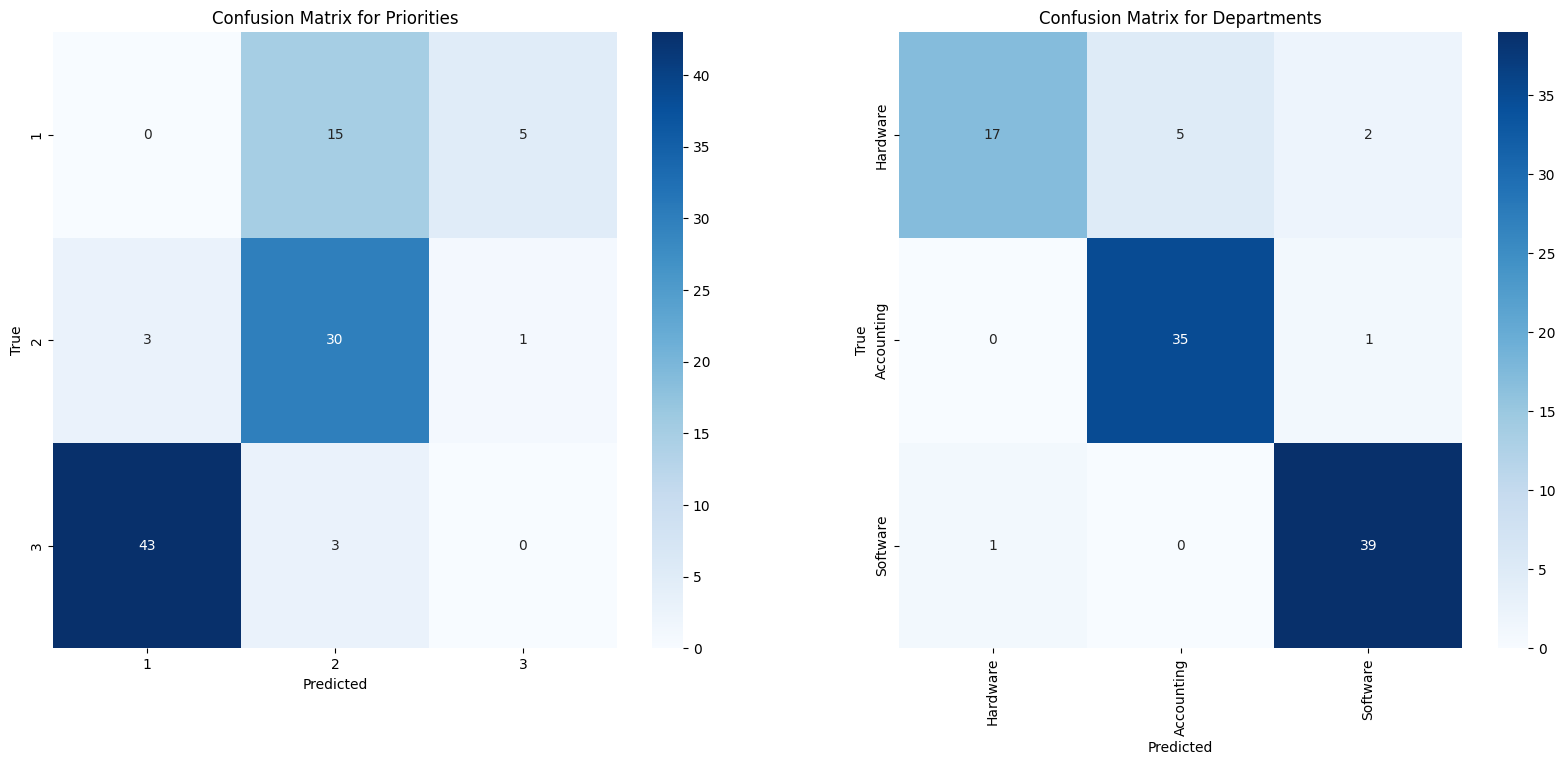

In [25]:
plot_confusion_matrix(true_values, responses)

In [82]:
responses = []

for index, row in tqdm(df_val.iterrows(), total=df_val.shape[0]):
    messages = [
        {
            "role": "user",
            "content": "Please assign a priority and a department to the following ticket.\n\n"
            + row["subject"]
            + "\n"
            + row["text"],
        },
    ]

    response = client.chat.completions.create(
        model="phi-4",
        messages=messages,
        response_format=schema,
        temperature=0.0,
        max_tokens=100,
        seed=42,
    )

    results = json.loads(response.choices[0].message.content)
    responses.append(results)

100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


In [83]:
calculate_scores(true_val_values, responses).head()

/Users/saschametzger/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Metric,Priority,Department
0,Accuracy,0.350000,0.850000
1,F1 Score,0.254545,0.827381
2,Recall,0.350000,0.850000
3,Precision,0.200000,0.883117


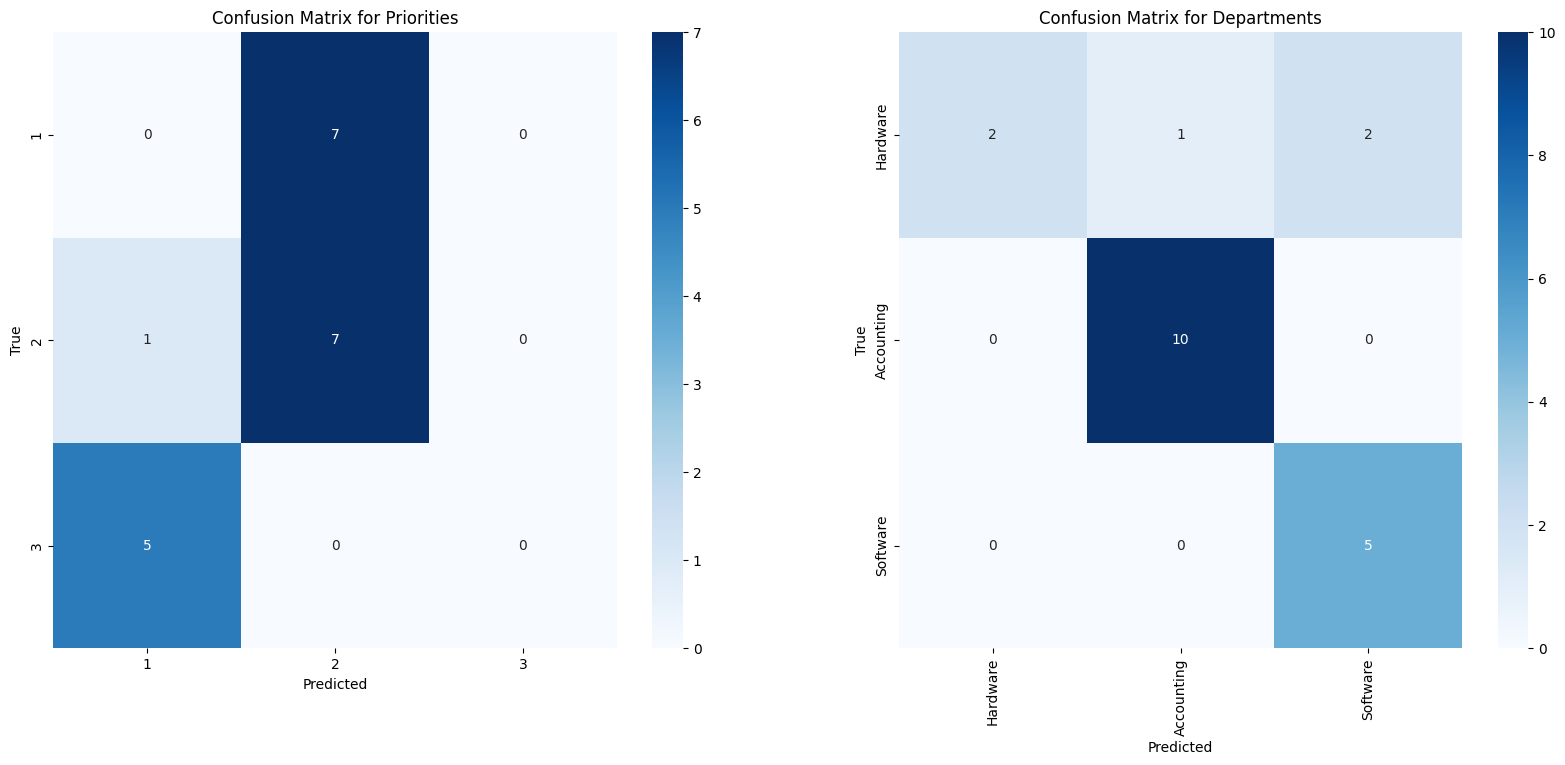

In [84]:
plot_confusion_matrix(true_val_values, responses)

## Improvements

### 1. Add System Prompt

In [26]:
system_prompt = """You are an AI service agent. Your job is to take an incoming customer support ticket, prioritize it and select a department for it.

Priorities can be:
- 3: High (High urgency, needs immediate attention)
- 2: Medium (Medium urgency, can wait a bit)
- 1: Low (Low urgency, can wait)

Departments can be one of the following:
- Hardware
- Accounting
- Software

Please analyze the ticket description and subject to determine the appropriate priority and department.

Answer in the following json format:
{
  "priority": [1, 2, 3],
  "department": ["Hardware", "Accounting", "Software"]
}
""".strip()

In [27]:
examples = []
for index, row in df_few_shot.iterrows():
    example = {
        "priority": row["priority"],
        "department": row["department"],
        "language": row["language"],
        "subject": row["subject"],
        "text": row["text"]
    }
    examples.append(example)

In [28]:
system_prompt = (
    system_prompt.strip()
    + "\n\n"
    + "Here are some examples of tickets and their corresponding priorities and departments:\n\n"
)

for i, example in enumerate(examples):
    system_prompt += f"\nExample {i+1}:\n"
    system_prompt += f"{example['subject'].strip()}\n\n"
    system_prompt += f"{example['text'].strip()}\n\n"
    system_prompt += "Response:\n"
    system_prompt += f"""{{
    "priority": {example['priority']},
    "department": "{example['department']}"
}}\n\n\n"""

In [29]:
print(system_prompt)

You are an AI service agent. Your job is to take an incoming customer support ticket, prioritize it and select a department for it.

Priorities can be:
- 3: High (High urgency, needs immediate attention)
- 2: Medium (Medium urgency, can wait a bit)
- 1: Low (Low urgency, can wait)

Departments can be one of the following:
- Hardware
- Accounting
- Software

Please analyze the ticket description and subject to determine the appropriate priority and department.

Answer in the following json format:
{
  "priority": [1, 2, 3],
  "department": ["Hardware", "Accounting", "Software"]
}

Here are some examples of tickets and their corresponding priorities and departments:


Example 1:
Inquiry regarding billing security protocols

Hello Support Team,
I would like to inquire about the security protocols you have in place regarding our billing and account information security. Can you provide details on how my financial data is protected? Ensuring safety and compliance is crucial for us.
Thank yo

In [30]:
responses = []

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    messages = [
        {"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": "Please assign a priority and a department to the following ticket.\n\n"
            + row["subject"]
            + "\n"
            + row["text"],
        },
    ]

    response=client.chat.completions.create(
        model="phi-4",
        messages=messages,
        response_format=schema,
        temperature=0.0,
        max_tokens=100,
        seed=42,
    )

    results = json.loads(response.choices[0].message.content)
    responses.append(results)

100%|██████████| 100/100 [01:55<00:00,  1.16s/it]


In [31]:
scores_df = calculate_scores(true_values, responses)
scores_df.head()

,Metric,Priority,Department
0,Accuracy,0.790000,0.970000
1,F1 Score,0.796217,0.970150
2,Recall,0.790000,0.970000
3,Precision,0.816925,0.972093


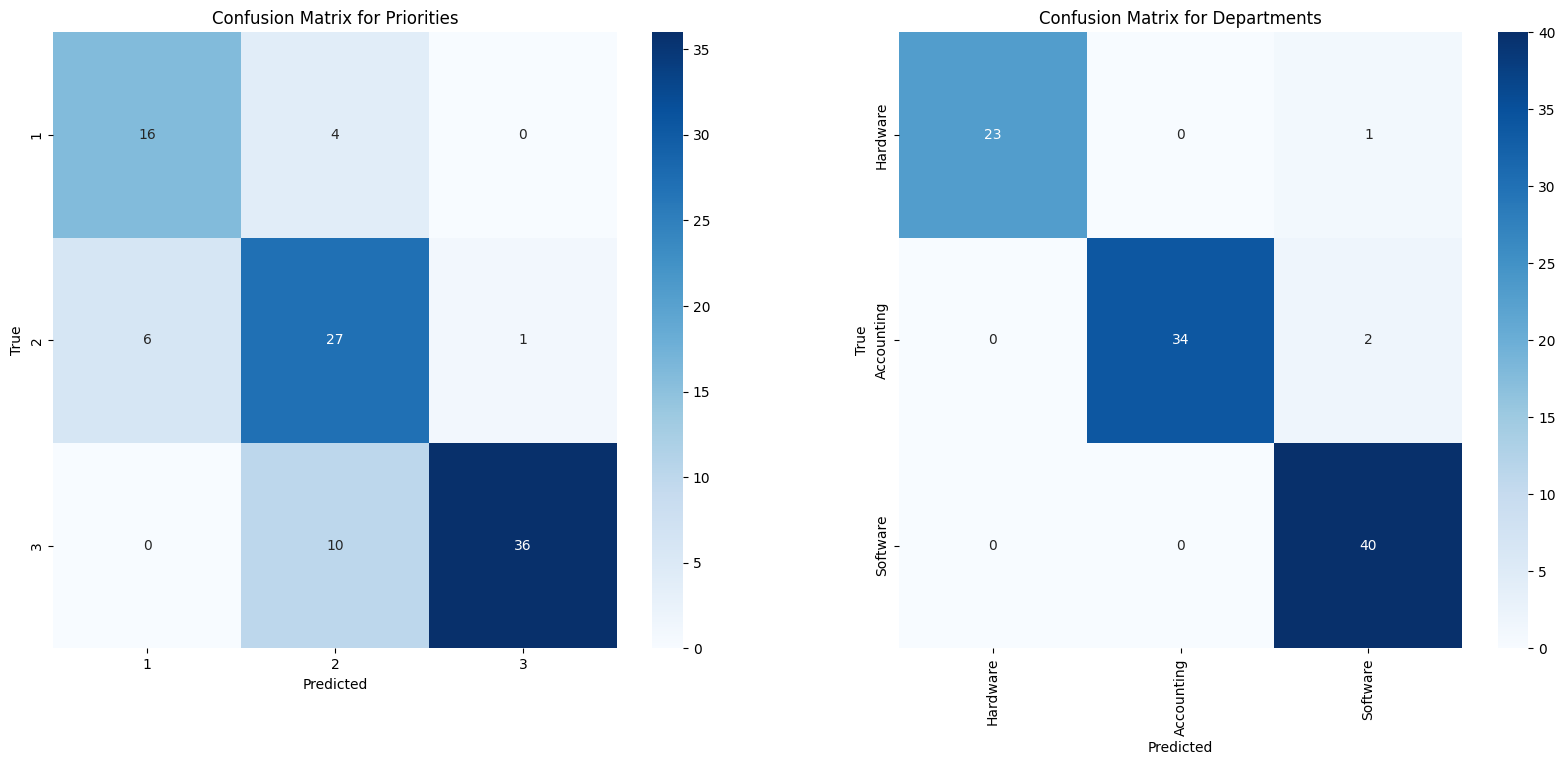

In [32]:
plot_confusion_matrix(true_values, responses)

### 2. Add an explanation for the prediction

In [33]:
## add an exmpty explanation column to the df_few_shot dataframe
df_few_shot['explanation'] = ""
df_few_shot

,department,priority,language,subject,text,explanation
30,Accounting,1,en,Inquiry regarding billing security protocols,"Hello Support Team,\nI would like to inquire a...",
67,Hardware,2,en,External Hard Drive not recognized,"Hi team, I recently purchased an external hard...",
56,Hardware,2,de,Grafikkarten-Problem bei Gaming PC,"Hallo Support, meine Grafikkarte läuft seit de...",
119,Accounting,2,en,Health Check Inquiry - Upcoming Schedule,"Hello HR Team,\nCould you please provide the s...",
85,Software,3,de,Duda zeigt Fehler 404 nach dem Login,"Hallo Support-Team,\n\nich habe ein ernsthafte...",


In [34]:
explanation_schema = {
    "type": "json_schema",
    "json_schema": {
        "name": "ticket_classification",
        "schema": {
            "type": "object",
            "properties": {
                "priority_decision": {"type": "string"},
                "department_assignment": {"type": "string"},
            },
            "required": ["priority", "department"],
        },
    },
}

In [35]:
# iterate over the df and let the AI write an explanation for each row explaining why it chose the priority and department
responses = []

for index, row in tqdm(df_few_shot.iterrows(), total=df_few_shot.shape[0]):
    messages = [
        {
            "role": "system",
            "content": "You are a senior customer support agent. Please provide a short and concise explanation on why you chose the priority (1 for low, 2 for medium and 3 for high) and department (Software, Hardware or Accounting) for the following ticket.",
        },
        {
            "role": "user",
            "content": "Here is the ticket:\n"
            + "Subject: "
            + row["subject"]
            + "\n"
            + "Message: "
            + row["text"]
            + "\nDepartment: "
            + row["department"]
            + "\nPriority: "
            + str(row["priority"]),
        },
    ]

    response = client.chat.completions.create(
        model="phi-4",
        messages=messages,
        response_format=explanation_schema,
        temperature=0.3,
        max_tokens=512,
        seed=42,
    )

    results = json.loads(response.choices[0].message.content)
    responses.append(results)

100%|██████████| 5/5 [00:22<00:00,  4.56s/it]


In [36]:
## add each explanation to the df_few_shot dataframe
df_few_shot['explanation'] = responses

In [37]:
system_prompt = """You are an AI service agent. Your job is to take an incoming customer support ticket, prioritize it and select a department for it.

Priorities can be:
- 3: High (High urgency, needs immediate attention)
- 2: Medium (Medium urgency, can wait a bit)
- 1: Low (Low urgency, can wait)

Departments can be one of the following:
- Hardware
- Accounting
- Software

Please analyze the ticket description and subject to determine the appropriate priority and department.

Answer in the following json format:
{
  "priority": [1, 2, 3],
  "department": ["Hardware", "Accounting", "Software"]
}
""".strip()

In [38]:
system_prompt = (
    system_prompt.strip()
    + "\n\n"
    + "Here are some examples of tickets and their corresponding priorities and departments as well as explanations for the choices:\n"
)

i = 0
for _, example in df_few_shot.iterrows():
    system_prompt += f"\nExample {i+1}:\n"
    system_prompt += f"{example['subject'].strip()}\n"
    system_prompt += f"{example['text'].strip()}\n\n"

    system_prompt += "Response:\n"
    system_prompt += f"""{{
    "priority": {example['priority']},
    "department": "{example['department']}"
}}\n\n\n"""

    system_prompt += "Explanation:\n"
    system_prompt += (
        f"Priority Decision: {example['explanation']['priority_decision']}\n"
    )
    system_prompt += f"Department Assignment: {example['explanation']['department_assignment']}\n\n\n"

    i += 1

In [39]:
print(system_prompt)

You are an AI service agent. Your job is to take an incoming customer support ticket, prioritize it and select a department for it.

Priorities can be:
- 3: High (High urgency, needs immediate attention)
- 2: Medium (Medium urgency, can wait a bit)
- 1: Low (Low urgency, can wait)

Departments can be one of the following:
- Hardware
- Accounting
- Software

Please analyze the ticket description and subject to determine the appropriate priority and department.

Answer in the following json format:
{
  "priority": [1, 2, 3],
  "department": ["Hardware", "Accounting", "Software"]
}

Here are some examples of tickets and their corresponding priorities and departments as well as explanations for the choices:

Example 1:
Inquiry regarding billing security protocols
Hello Support Team,
I would like to inquire about the security protocols you have in place regarding our billing and account information security. Can you provide details on how my financial data is protected? Ensuring safety and 

In [40]:
responses = []

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    messages = [
        {"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": "Please assign a priority and a department to the following ticket.\n\n"
            + row["subject"]
            + "\n"
            + row["text"],
        },
    ]

    response=client.chat.completions.create(
        model="phi-4",
        messages=messages,
        response_format=schema,
        temperature=0.0,
        max_tokens=100,
        seed=42,
    )

    results = json.loads(response.choices[0].message.content)
    responses.append(results)

100%|██████████| 100/100 [02:04<00:00,  1.24s/it]


In [41]:
calculate_scores(true_values, responses).head()

,Metric,Priority,Department
0,Accuracy,0.770000,0.990000
1,F1 Score,0.774905,0.989955
2,Recall,0.770000,0.990000
3,Precision,0.788019,0.990244


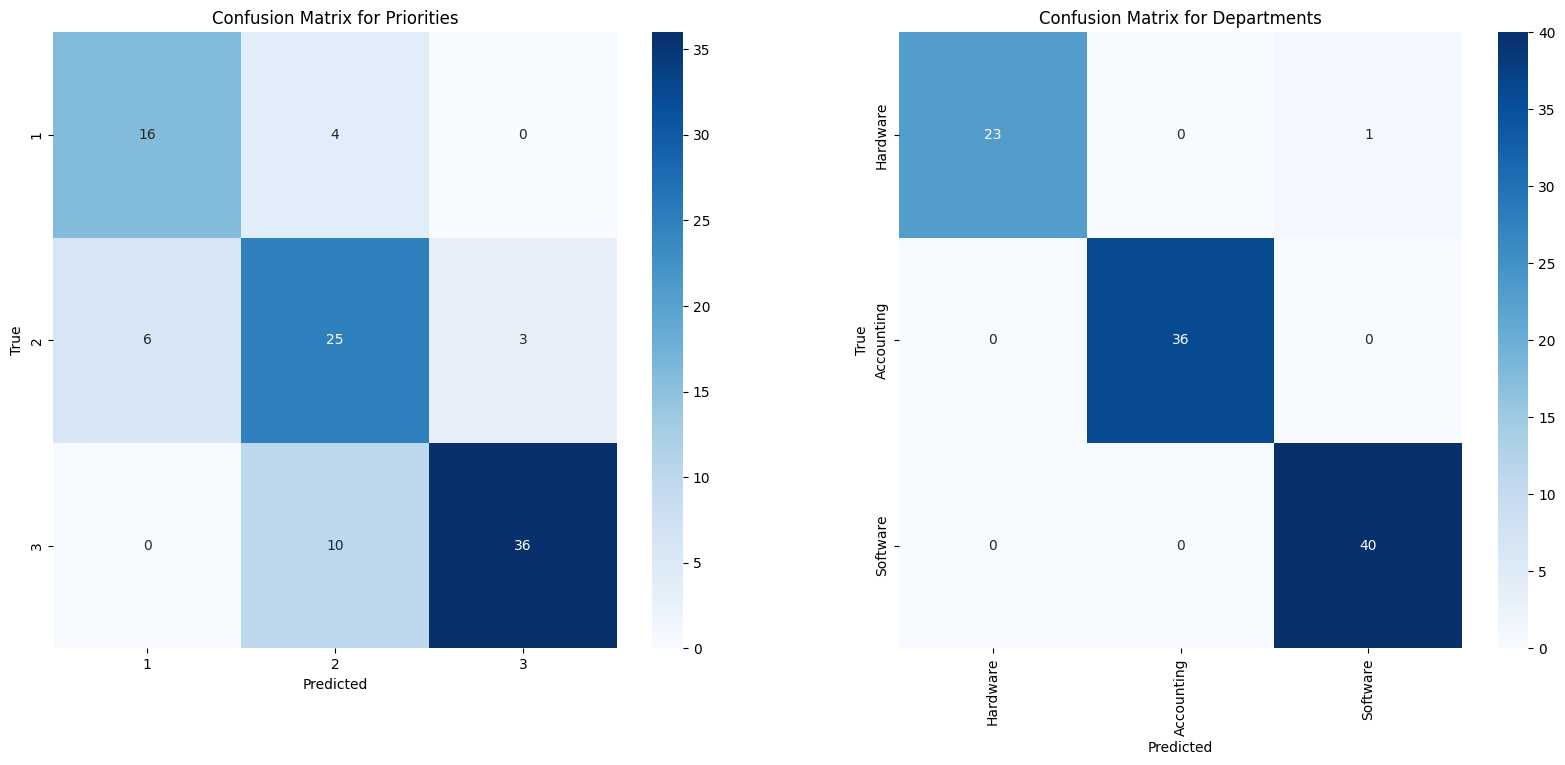

In [42]:
plot_confusion_matrix(true_values, responses)

### HPO

In [43]:
# There are many hyperparameters that can be tuned to improve the model's performance (e.g. temperature, max_tokens, etc.). We will only focus on the temperature and seed parameter in this example.
temp_range = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
seed_range = [42, 1331, 2022, 307, 5000]

possible_combinations = [(temp, seed) for temp in temp_range for seed in seed_range]
len(possible_combinations)

30

In [44]:
def hpo_temperature(temp, seed):
    responses = []

    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        messages = [
            {"role": "system", "content": system_prompt},
            {
                "role": "user",
                "content": "Please assign a priority and a department to the following ticket.\n\n"
                + row["subject"]
                + "\n"
                + row["text"],
            },
        ]

        response = client.chat.completions.create(
            model="phi-4",
            messages=messages,
            response_format=schema,
            temperature=temp,
            max_tokens=100,
            seed=seed,
        )

        results = json.loads(response.choices[0].message.content)
        responses.append(results)

    return calculate_scores(true_values, responses)

In [ ]:
scores = []

# for each possible combination of temperature and seed, calculate the scores and save them
for temp, seed in tqdm(possible_combinations):
    scores_df = hpo_temperature(temp, seed)
    scores_df["temperature"] = temp
    scores_df["seed"] = seed
    scores.append(scores_df)

In [56]:
scores[0]

,Metric,Priority,Department,temperature,seed
0,Accuracy,0.770000,0.990000,0.0,42
1,F1 Score,0.774905,0.989955,0.0,42
2,Recall,0.770000,0.990000,0.0,42
3,Precision,0.788019,0.990244,0.0,42


In [66]:
best_f1_score = scores[0].values[1][1:3].mean()
best_score = scores[0]

# iterate over all scores and find the best f1 score
for score in scores:
    f1_score = score.values[1][1:3].mean()
    if f1_score > best_f1_score:
        best_f1_score = f1_score
        best_score = score

best_score

,Metric,Priority,Department,temperature,seed
0,Accuracy,0.790000,0.990000,0.4,307
1,F1 Score,0.794447,0.989955,0.4,307
2,Recall,0.790000,0.990000,0.4,307
3,Precision,0.808518,0.990244,0.4,307


## Evaluate against Validation Set

In [76]:
responses = []

for index, row in tqdm(df_val.iterrows(), total=df_val.shape[0]):
    messages = [
        {"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": "Please assign a priority and a department to the following ticket.\n\n"
            + row["subject"]
            + "\n"
            + row["text"],
        },
    ]

    response = client.chat.completions.create(
        model="phi-4",
        messages=messages,
        response_format=schema,
        temperature=float(best_score["temperature"].values[0]),
        seed=float(best_score["seed"].values[0]),
        max_tokens=100,
    )

    results = json.loads(response.choices[0].message.content)
    responses.append(results)

100%|██████████| 20/20 [00:24<00:00,  1.24s/it]


In [78]:
calculate_scores(true_val_values, responses).head()

,Metric,Priority,Department
0,Accuracy,0.750000,0.950000
1,F1 Score,0.743939,0.949495
2,Recall,0.750000,0.950000
3,Precision,0.744048,0.958333


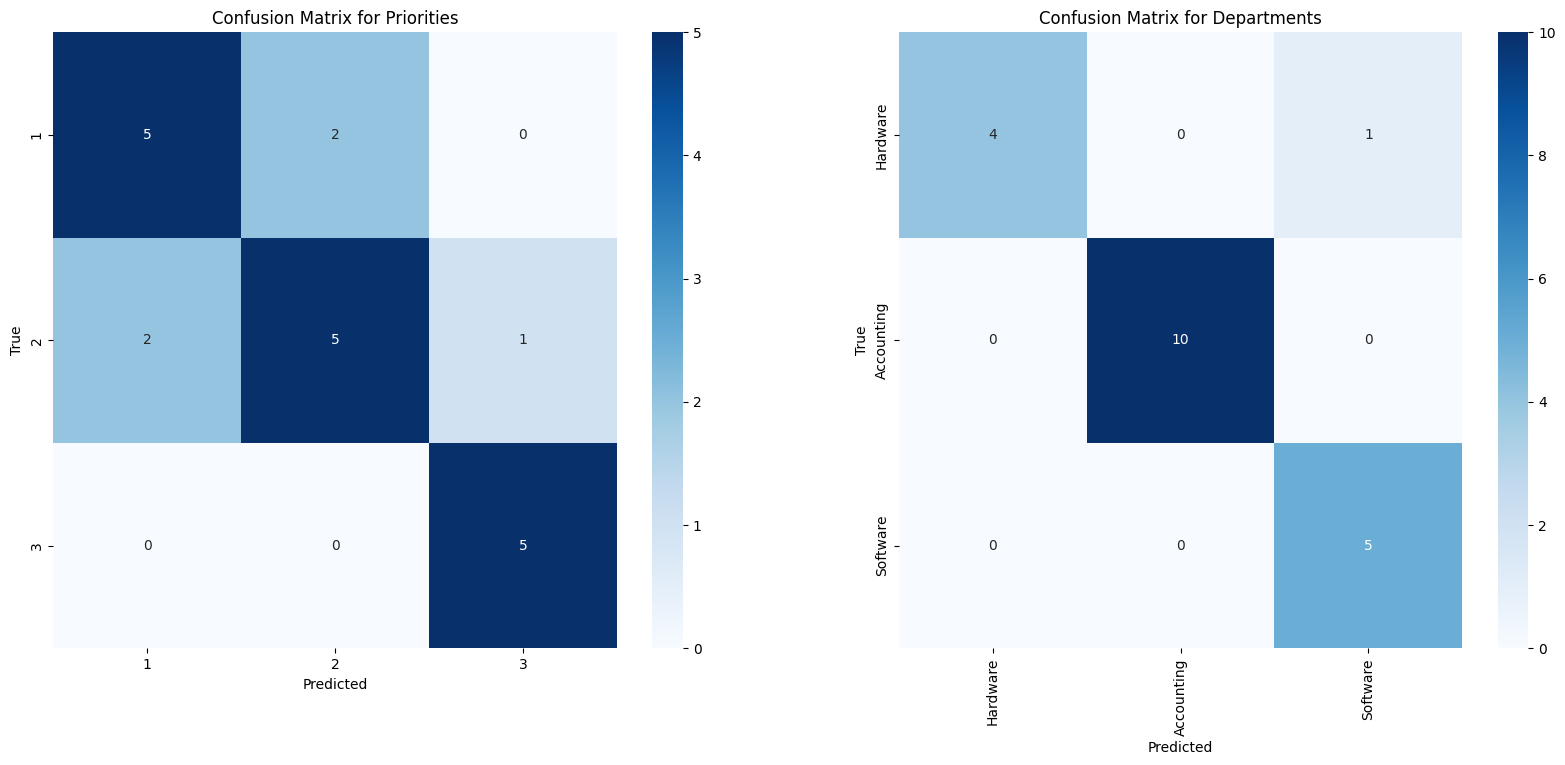

In [80]:
plot_confusion_matrix(true_val_values, responses)

## Conclusion

In [87]:
print("The best temperature and seed combination is:")
print("Temperature:", best_score["temperature"].values[0])
print("Seed:", best_score["seed"].values[0])

The best temperature and seed combination is:
Temperature: 0.4
Seed: 307


In [91]:
print(system_prompt)

You are an AI service agent. Your job is to take an incoming customer support ticket, prioritize it and select a department for it.

Priorities can be:
- 3: High (High urgency, needs immediate attention)
- 2: Medium (Medium urgency, can wait a bit)
- 1: Low (Low urgency, can wait)

Departments can be one of the following:
- Hardware
- Accounting
- Software

Please analyze the ticket description and subject to determine the appropriate priority and department.

Answer in the following json format:
{
  "priority": [1, 2, 3],
  "department": ["Hardware", "Accounting", "Software"]
}

Here are some examples of tickets and their corresponding priorities and departments as well as explanations for the choices:

Example 1:
Inquiry regarding billing security protocols
Hello Support Team,
I would like to inquire about the security protocols you have in place regarding our billing and account information security. Can you provide details on how my financial data is protected? Ensuring safety and 